## Brief on the use of anchors in Faster RCNN

*  Anchors allow object detection model to predict froma fixed set of images patches instead of detecting them from scratch.
*  Anchors have different sizes and ratios to accomodate the fact that detecting objects are of different shapes
*  Having set of anchors closer to the conditions to be detected  thing would improve the prediction performance and training time
*  

In [1]:
%cd /projappl/project_2006327/Detectron/datasets/2024

/projappl/project_2006327/Detectron/datasets/2024


## Register datasets

In [2]:
from detectron2.utils.logger import setup_logger
logger = setup_logger()

In [3]:
from detectron2.data.datasets import register_coco_instances

In [4]:
# Some configurations
name_ds = "coco_data"
name_ds_train = name_ds + "_train"
image_root_train = name_ds + "/train"
af = "_annotations.coco.json"
json_file_train = name_ds + "/train/" + af

In [5]:
# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )

### Training configuration

In [6]:
import os
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle

In [7]:
output_dir = "output/object_detector_hook"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")
nc = 1
device = "cuda"
# Select a model
config_file_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

In [8]:
# Create a configuration file
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Download weights
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Set datasets
cfg.DATASETS.TRAIN = (name_ds_train,)

# set the size of the input images
cfg.INPUT.MIN_SIZE_TRAIN = (640,)
cfg.INPUT.MAX_SIZE_TRAIN = 640

# Workers
cfg.DATALOADER.NUM_WORKERS = 2
# Images per batch
cfg.SOLVER.IMS_PER_BATCH = 6
# Learning rate
cfg.SOLVER.BASE_LR = 0.00025
# Iterations
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.CHECKPOINT_PERIOD = 100
# Evaluation
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD
# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir

### A trainer

In [9]:
from detectron2.engine import DefaultTrainer
trainer = DefaultTrainer(cfg)

[02/05 14:11:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## Preprocessing Input Images

In [10]:
#display the config for image resizing augmentations
print("MIN_SIZE_TRAIN", cfg.INPUT.MIN_SIZE_TRAIN)
print("MAX_SIZE_TRAIN", cfg.INPUT.MAX_SIZE_TRAIN)

MIN_SIZE_TRAIN (640,)
MAX_SIZE_TRAIN 640


In [11]:
trainer._data_loader_iter = iter(trainer.data_loader)
data = next(trainer._data_loader_iter)
for i in data:
  print(i['image'].shape)

torch.Size([3, 640, 640])
torch.Size([3, 640, 640])
torch.Size([3, 640, 640])
torch.Size([3, 640, 640])
torch.Size([3, 640, 640])
torch.Size([3, 640, 640])


In [12]:
images = trainer.model.preprocess_image(data)
print(images.tensor.shape)

torch.Size([6, 3, 640, 640])


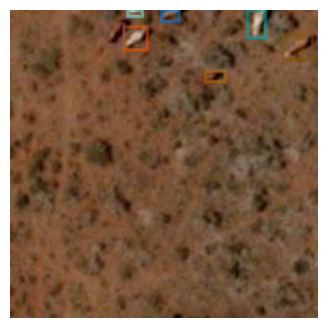

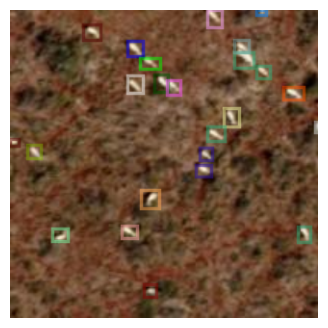

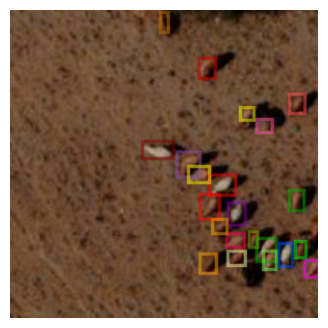

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer

for i, item in enumerate(images.tensor[:3]):
  img = np.moveaxis(item.to("cpu").numpy(), 0, -1)
  pixel_mean = cfg.MODEL.PIXEL_MEAN
  pixel_std = cfg.MODEL.PIXEL_STD
  img = (img * pixel_std) + pixel_mean
  v = Visualizer(img, metadata={}, scale=0.5)
  v = v.overlay_instances(boxes=data[i]['instances'].get('gt_boxes'))
  dpi = 80
  im_data = v.get_image()[:,:, ::-1]
  height, width, depth = im_data.shape
  figsize = width / float(dpi), height / float(dpi)
  fig = plt.figure(figsize=figsize)
  plt.imshow(im_data)
  plt.imshow(im_data)
  plt.axis("off")
  plt.show()

## Sampling training data and generating the default anchors

In [14]:
from tqdm import tqdm
import torch
def get_gt_boxes_batch(data):
  gt_boxes = [
      item['instances'].get('gt_boxes').tensor 
      for item in data
      ]
  return torch.concatenate(gt_boxes)

def get_gt_boxes(trainer, iterations):
  trainer._data_loader_iter = iter(trainer.data_loader)
  gt_boxes = [
      get_gt_boxes_batch(next(trainer._data_loader_iter)) 
      for _ in tqdm(range(iterations))
      ]
  return torch.concatenate(gt_boxes)
  
gt_boxes = get_gt_boxes(trainer, 1000)
print()
print(gt_boxes.shape)

100%|██████████| 1000/1000 [02:08<00:00,  7.76it/s]


torch.Size([56248, 4])


In [15]:
def boxes2wh(boxes):
  x1y1 = boxes[:, :2]
  x2y2 = boxes[:, 2:]
  return x2y2 - x1y1

gt_wh = boxes2wh(gt_boxes)
print(gt_wh.min(), gt_wh.max())

tensor(2.7789) tensor(128.3168)


In [16]:
print("sizes", cfg.MODEL.ANCHOR_GENERATOR.SIZES)
print("ratios", cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS)

sizes [[32], [64], [128], [256], [512]]
ratios [[0.5, 1.0, 2.0]]


In [17]:
generate_anchors = trainer.model.proposal_generator.anchor_generator.generate_cell_anchors
anchors = generate_anchors()
ac_wh = boxes2wh(anchors)

## Generating sizes and ratios hyperparameters

In [18]:
def wh2size(wh):
  return torch.sqrt(gt_wh[:, 0]*gt_wh[:, 1])

def wh2ratio(wh):
  return wh[:, 1]/wh[:,0]

gt_sizes = wh2size(gt_wh)
gt_ratios = wh2ratio(gt_wh)

In [19]:
def best_ratio(ac_wh, gt_wh):
  all_ratios = gt_wh[:, None] / ac_wh[None]
  inverse_ratios = 1/all_ratios
  ratios = torch.min(
      all_ratios, inverse_ratios
  )
  worst = ratios.min(-1).values
  best = worst.max(-1).values
  return best

In [20]:
def fitness(ac_wh, gt_wh, EDGE_RATIO_THRESHOLD = 0.25):
  ratio = best_ratio(ac_wh, gt_wh)
  return (ratio * (ratio > EDGE_RATIO_THRESHOLD).float()).mean()

In [21]:
def best_recall(ac_wh, gt_wh, EDGE_RATIO_THRESHOLD = 0.25):
  ratio = best_ratio(ac_wh, gt_wh)
  best = (ratio > EDGE_RATIO_THRESHOLD).float().mean()
  return best

In [22]:
print("recall", best_recall(ac_wh, gt_wh))
print("fitness", fitness(ac_wh, gt_wh))

recall tensor(0.9998)
fitness tensor(0.7489)


In [23]:
import numpy as np
plt.rcParams["figure.dpi"] = 150
from scipy.cluster.vq import kmeans
def estimate_clusters(values, num_clusters, iter=100):
  std = values.std(0).item()
  k, _ = kmeans(values / std, num_clusters, iter=iter)
  k *= std
  return k

def visualize_clusters(values, centers):
  plt.hist(values, histtype='step')
  plt.scatter(centers, [0]*len(centers), c= "red")
  plt.show()

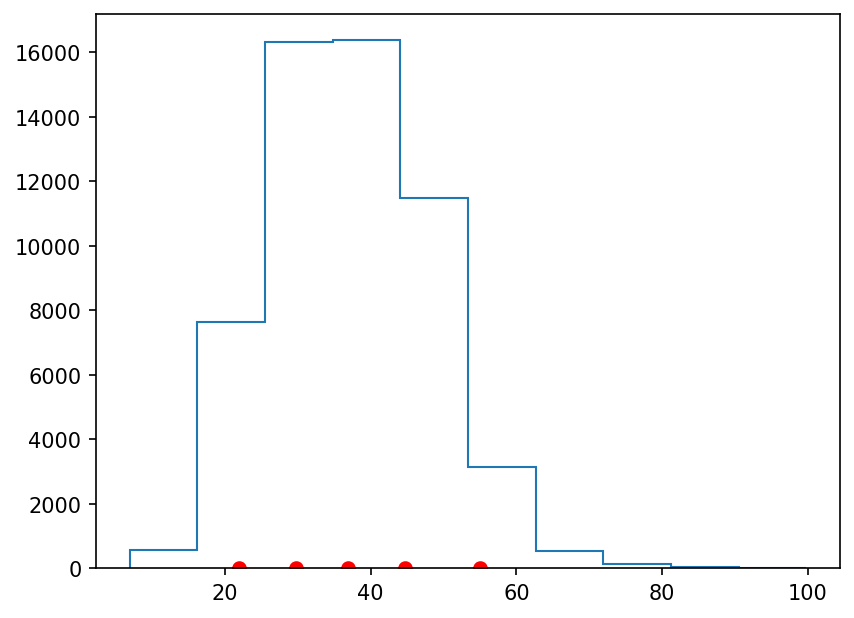

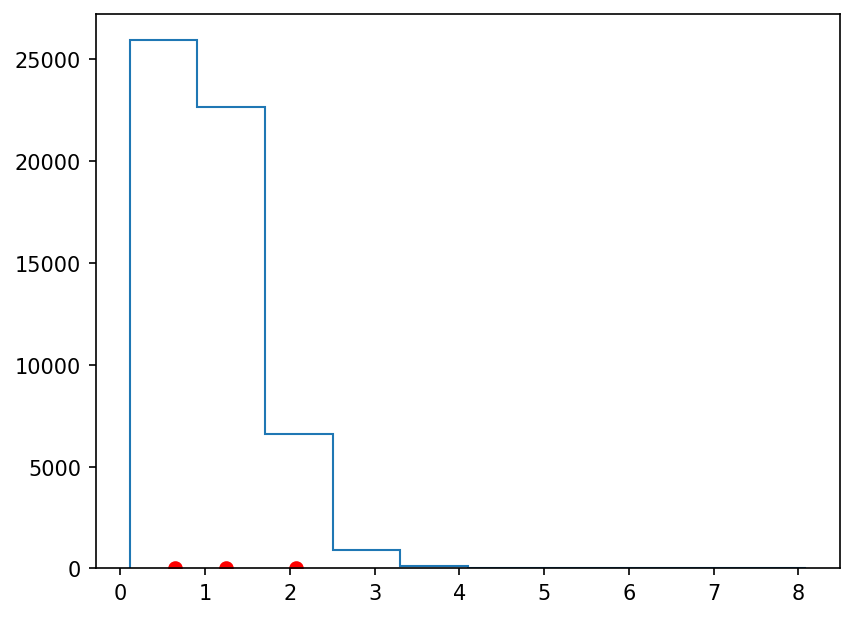

In [24]:
sizes = estimate_clusters(gt_sizes, 5)
visualize_clusters(gt_sizes, sizes)
ratios = estimate_clusters(gt_ratios, 3)
visualize_clusters(gt_ratios, ratios)

In [25]:
fitness(boxes2wh(generate_anchors(sizes, ratios)), gt_wh)

tensor(0.8598, dtype=torch.float64)

## Evolve the results using the Genetic Algorithm

In [26]:
def evolve(sizes, ratios, 
           gt_wh, 
           iterations=10000, 
           probability=0.9, 
           muy=1, 
           sigma=0.05, 
           fit_fn=fitness, 
           verbose=False):
  anchors = generate_anchors(tuple(sizes), tuple(ratios))
  ac_wh = boxes2wh(anchors)
  best_fit = fit_fn(ac_wh, gt_wh)
  anchor_shape = len(sizes) + len(ratios)

  pbar = tqdm(range(iterations), desc=f"Evolving ratios and sizes:")
  for i, _ in enumerate(pbar):
      # to mutate and how much
      mutation = np.ones(anchor_shape)
      mutate = np.random.random(anchor_shape) < probability
      mutation = np.random.normal(muy, sigma, anchor_shape)*mutate
      mutation = mutation.clip(0.3, 3.0)
      # mutated
      mutated_sizes = sizes.copy()*mutation[:len(sizes)]
      mutated_ratios = ratios.copy()*mutation[-len(ratios):]
      mutated_anchors = generate_anchors(
          tuple(mutated_sizes), 
          tuple(mutated_ratios))
      mutated_ac_wh = boxes2wh(mutated_anchors)
      mutated_fit = fit_fn(mutated_ac_wh, gt_wh)

      if mutated_fit > best_fit:
        sizes = mutated_sizes.copy()
        ratios = mutated_ratios.copy()
        best_fit = mutated_fit
        pbar.desc = (f"Evolving ratios and sizes, Fitness = {best_fit:.4f}")
  return sizes, ratios

In [27]:
e_sizes, e_ratios = evolve(sizes, ratios, gt_wh, verbose=False)

Evolving ratios and sizes, Fitness = 0.8680: 100%|██████████| 10000/10000 [01:54<00:00, 87.51it/s]


In [28]:
print("sizes", e_sizes)
print("ratios", e_ratios)

sizes [43.48403622 29.42209169 36.92428582 52.30700844 22.32369148]
ratios [0.56776786 1.60585184 0.95999676]
